# 用于验证回测框架的独立程序 (V3 - 完全单利模型)

**目的**: 根据带教老师要求，将整个回测框架的计算逻辑从复利模型修改为单利模型。

**核心变更**:
1.  权益曲线使用 `cumsum` (累积和) 进行计算。
2.  所有收益聚合 (月度、年度) 均使用 `sum`。
3.  单笔交易盈亏使用 `sum` 计算。
4.  年化收益率使用算术平均。
5.  所有相关指标均基于单利模型重新计算。

In [1]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path

---
## 1. 日志和绘图设置

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数 (源于您的代码)

In [3]:
def run_vectorized_backtest(prices, signals, initial_capital=100000, commission_rate=0.0005, long_threshold=0.001, short_threshold=-0.001):
    """
    执行向量化回测（完全基于单利模型）。
    """
    logging.info("🤔🤔开始执行向量化回测 (单利模型)...")
    
    # --- 1. 生成交易信号和持仓 (逻辑不变) ---
    positions = pd.Series(np.select(
        [signals > long_threshold, signals < short_threshold],
        [1, -1],
        default=0
    ), index=signals.index)
    positions = positions.shift(1).fillna(0)
    
    # --- 2. 计算收益 (逻辑不变) ---
    market_returns = prices.pct_change().fillna(0)
    strategy_returns = positions * market_returns

    # --- 3. 计算交易成本 (逻辑不变) ---
    trades = positions.diff().fillna(0)
    transaction_costs = abs(trades) * commission_rate
    strategy_net_returns = strategy_returns - transaction_costs
    
    # --- 4. 计算权益曲线 (## MODIFIED: 使用单利模型) ---
    # 在单利模型中，每期的盈亏金额是基于固定的初始资本计算的
    pnl_per_period = strategy_net_returns * initial_capital
    
    # 累积盈亏是每期盈亏金额的算术和
    cumulative_pnl = pnl_per_period.cumsum()
    
    # 最终权益曲线是初始资本加上累积的盈亏
    equity_curve = initial_capital + cumulative_pnl
    
    # --- 5. 整合结果 ---
    backtest_results = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'position': positions,
        'market_returns': market_returns,
        'strategy_returns': strategy_returns,
        'transaction_costs': transaction_costs,
        'strategy_net_returns': strategy_net_returns,
        'equity_curve': equity_curve
    })
    
    logging.info("🎉🎉向量化回测完成 (单利模型)。")
    return backtest_results

In [4]:
def evaluate_performance(backtest_results, evaluation_criteria, initial_capital, factor_data=None):
    logging.info("🤔🤔🤔开始评估策略表现 (单利模型)...")

    equity_curve = backtest_results['equity_curve']
    net_returns = backtest_results['strategy_net_returns']
    market_returns = backtest_results['market_returns']
    positions = backtest_results['position']
    trades_raw = positions.diff().fillna(0)
    
    # --- 识别单笔交易盈亏 (## MODIFIED: 使用单利求和) ---
    individual_trade_pnl_list = []
    current_position_type = 0
    entry_time = None

    for i in range(1, len(positions)):
        prev_pos, curr_pos = positions.iloc[i-1], positions.iloc[i]
        
        # 定义一个辅助函数来计算单笔交易的单利收益
        def calculate_simple_pnl(start_idx, end_idx):
            # 直接对期间内的净收益率求和
            return backtest_results['strategy_net_returns'].iloc[start_idx:end_idx].sum()

        if prev_pos != 0 and curr_pos == 0: # 平仓
            if entry_time is not None:
                entry_idx = backtest_results.index.get_loc(entry_time)
                trade_pnl = calculate_simple_pnl(entry_idx + 1, i + 1)
                individual_trade_pnl_list.append(trade_pnl)
            current_position_type, entry_time = 0, None
        
        elif prev_pos == 0 and curr_pos != 0: # 开仓
            current_position_type, entry_time = curr_pos, backtest_results.index[i]
        
        elif prev_pos != 0 and curr_pos != 0 and prev_pos != curr_pos: # 反手
            if entry_time is not None:
                entry_idx = backtest_results.index.get_loc(entry_time)
                trade_pnl = calculate_simple_pnl(entry_idx + 1, i + 1)
                individual_trade_pnl_list.append(trade_pnl)
            current_position_type, entry_time = curr_pos, backtest_results.index[i]
            
    if current_position_type != 0 and entry_time is not None: # 处理期末未平仓位
        entry_idx = backtest_results.index.get_loc(entry_time)
        trade_pnl = calculate_simple_pnl(entry_idx + 1, len(backtest_results))
        individual_trade_pnl_list.append(trade_pnl)

    trade_returns_series = pd.Series(individual_trade_pnl_list)

    # --- 1. 计算核心指标 (## MODIFIED: 全面适配单利模型) ---
    annualization_factor = 12 
    total_days = (equity_curve.index[-1] - equity_curve.index[0]).days if len(equity_curve) > 1 else 0
    duration_years = total_days / 365.0 if total_days > 0 else 1 

    # 1. 总收益率 (Total Return) - 计算方式不变，但数值会因equity_curve改变而改变
    total_return = (equity_curve.iloc[-1] / initial_capital) - 1 if initial_capital != 0 else 0

    # 2. 年化收益率 (Annualized Return) - ## MODIFIED: 使用算术年化
    annualized_return = total_return / duration_years if duration_years > 0 else 0

    # ## MODIFIED: 使用 .sum() 聚合月度收益
    monthly_net_returns = net_returns.resample('M').sum().dropna()
    monthly_market_returns = market_returns.resample('M').sum().dropna()

    # 3. 年化波动率 (Annualized Volatility) - 基于单利月度收益计算
    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        annualized_volatility = monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        annualized_volatility = 0

    # 4. 最大回撤 (MDD) - 计算方式不变，但数值会因equity_curve改变而改变
    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = abs(drawdown.min())
    end_date_idx = drawdown.idxmin()
    peak_idx = equity_curve.loc[:end_date_idx].idxmax() if end_date_idx is not None else None
    max_drawdown_start_date = peak_idx
    max_drawdown_end_date = end_date_idx

    # 5. 夏普比率 (Sharpe Ratio) - 基于单利月度收益计算
    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        sharpe_ratio = monthly_net_returns.mean() / monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        sharpe_ratio = 0

    # 6. 卡玛比率 (Calmar Ratio) - 基于新的年化收益和MDD
    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else 0

    # 7. 交易统计 - 基于新的单利单笔交易盈亏
    winning_trades_pnl = trade_returns_series[trade_returns_series > 0]
    losing_trades_pnl = trade_returns_series[trade_returns_series <= 0]
    total_trades = len(trade_returns_series)
    num_winning_trades = len(winning_trades_pnl)
    num_losing_trades = len(losing_trades_pnl)
    win_rate = num_winning_trades / total_trades if total_trades > 0 else 0
    total_profit_amount_trades = winning_trades_pnl.sum()
    total_loss_amount_trades = abs(losing_trades_pnl.sum())
    profit_loss_ratio = total_profit_amount_trades / total_loss_amount_trades if total_loss_amount_trades > 0 else np.inf
    expectancy = (win_rate * profit_loss_ratio) - (1 - win_rate) if win_rate > 0 and profit_loss_ratio != np.inf else -1
    
    # 8. 每周开仓频率
    open_positions = trades_raw[(trades_raw == 1) | (trades_raw == -1)]
    num_open_trades = len(open_positions)
    total_weeks = len(pd.date_range(start=equity_curve.index[0], end=equity_curve.index[-1], freq=Week()))
    weekly_trade_frequency = num_open_trades / total_weeks if total_weeks > 0 else 0

    # 10. 索提诺比率 (Sortino Ratio)
    downside_monthly_returns = monthly_net_returns[monthly_net_returns < 0]
    if not downside_monthly_returns.empty and downside_monthly_returns.std() != 0:
        downside_std = downside_monthly_returns.std()
        sortino_ratio = monthly_net_returns.mean() / downside_std * np.sqrt(annualization_factor)
    else:
        sortino_ratio = 0
        
    # 11. 平均盈利和平均亏损
    average_win = winning_trades_pnl.mean() if num_winning_trades > 0 else 0
    average_loss = losing_trades_pnl.mean() if num_losing_trades > 0 else 0
    
    # 12. 总盈亏金额 (Total PnL)
    total_pnl_amount = equity_curve.iloc[-1] - initial_capital

    # 13. 逐年收益率 (Annual Returns) - ## MODIFIED: 使用 .sum() 聚合
    annual_returns = net_returns.resample('Y').sum()
    annual_returns.index = annual_returns.index.year

    # --- 超额指标计算 (## MODIFIED: 全面适配单利模型) ---
    # 基准权益曲线 (Buy & Hold) - 同样使用单利计算以保证可比性
    benchmark_pnl_per_period = market_returns * initial_capital
    benchmark_equity = initial_capital + benchmark_pnl_per_period.cumsum()
    
    # 超额收益率 (Excess Return) - ## MODIFIED: 使用算术相减
    excess_monthly_returns_series = (monthly_net_returns - monthly_market_returns).dropna()

    # 超额权益曲线 (Excess Equity Curve) - ## MODIFIED: 使用cumsum
    if not excess_monthly_returns_series.empty:
        # 超额权益可以被视为一个初始资金为0，只累加超额Pnl的组合
        excess_pnl_curve = (excess_monthly_returns_series * initial_capital).cumsum()
        excess_equity_curve = initial_capital + excess_pnl_curve # 为了绘图起点一致
    else:
        excess_equity_curve = pd.Series([initial_capital], index=[equity_curve.index[0]])

    # 年化超额收益率 - ## MODIFIED: 使用算术年化
    total_excess_return = (excess_equity_curve.iloc[-1] / initial_capital) - 1 if not excess_equity_curve.empty else 0
    annualized_excess_return = total_excess_return / duration_years if duration_years > 0 else 0

    # 超额波动率
    excess_volatility = excess_monthly_returns_series.std() * np.sqrt(annualization_factor) if not excess_monthly_returns_series.empty and excess_monthly_returns_series.std() != 0 else 0
    
    # 超额最大回撤
    excess_max_drawdown = 0
    if not excess_equity_curve.empty:
        excess_running_max = excess_equity_curve.cummax()
        excess_drawdown = (excess_equity_curve - excess_running_max) / excess_running_max
        excess_max_drawdown = abs(excess_drawdown.min())

    # 超额夏普比率
    excess_sharpe_ratio = excess_monthly_returns_series.mean() / excess_monthly_returns_series.std() * np.sqrt(annualization_factor) if not excess_monthly_returns_series.empty and excess_monthly_returns_series.std() != 0 else 0

    # 换手率 (Turnover)
    value_traded_per_period = abs(trades_raw) * backtest_results['close']
    total_value_traded = value_traded_per_period.sum()
    average_aum = equity_curve.mean()
    annualized_turnover = (total_value_traded / average_aum) / duration_years if average_aum > 0 and duration_years > 0 else 0
    
    # --- 2. 打印评估报告 ---
    print("\n" + "="*80)
    print(Fore.CYAN + " " * 25 + "策略性能评估报告 (单利模型)" + " " * 25 + Style.RESET_ALL)
    print("="*80)
    
    def format_check(name, value, req_value, req_prefix, comp_func):
        status = "✅ 达标" if comp_func(value, req_value) else "❌ 未达标"
        req_str = f"{req_prefix} {req_value}"
        color = Fore.GREEN if comp_func(value, req_value) else Fore.RED
        return [name, f"{value:.4f}", req_str, color + status + Style.RESET_ALL]

    print("\n" + Fore.BLUE + Style.BRIGHT + "="*30 + " 收益指标 " + "="*30 + Style.RESET_ALL)
    sharpe_req = evaluation_criteria['sharpe_ratio']
    calmar_req = evaluation_criteria['calmar_ratio']
    expectancy_req = evaluation_criteria['expectancy']
    
    sharpe_ok = sharpe_ratio > sharpe_req
    calmar_ok = calmar_ratio > calmar_req
    expectancy_ok = expectancy > expectancy_req
    
    profit_plan1_ok = sharpe_ok and calmar_ok
    profit_plan2_ok = expectancy_ok
    profit_ok = profit_plan1_ok or profit_plan2_ok
    
    headers = ["指标名称", "计算结果", "要求", "状态"]
    profit_table = [
        format_check("夏普比率 (Sharpe)", sharpe_ratio, sharpe_req, ">", lambda v, r: v > r),
        format_check("卡玛比率 (Calmar)", calmar_ratio, calmar_req, ">", lambda v, r: v > r),
        format_check("期望收益 (Expectancy)", expectancy, expectancy_req, ">", lambda v, r: v > r)
    ]
    
    print(tabulate(profit_table, headers=headers, tablefmt="grid", stralign="center", numalign="center"))
    
    plan_table = [
        ["方案一 (夏普 & 卡玛)", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_plan1_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["方案二 (期望收益)", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_plan2_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合收益指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if profit_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print("\n" + tabulate(plan_table, headers=["策略方案", "状态"], tablefmt="grid", stralign="center"))
    
    long_positions_count = len(positions[positions == 1])
    short_positions_count = len(positions[positions == -1])
    total_positions_count = long_positions_count + short_positions_count
    
    position_table = [
        ["多头持仓占比", f"{long_positions_count/total_positions_count:.2%}" if total_positions_count > 0 else "0.00%"],
        ["空头持仓占比", f"{short_positions_count/total_positions_count:.2%}" if total_positions_count > 0 else "0.00%"]
    ]
    print("\n" + tabulate(position_table, headers=["持仓统计", ""], tablefmt="grid", stralign="center"))

    print("\n" + Fore.YELLOW + Style.BRIGHT + "="*30 + " 风控与效率指标 " + "="*30 + Style.RESET_ALL)
    mdd_req = evaluation_criteria['max_drawdown']
    freq_req = evaluation_criteria['weekly_frequency']
    
    mdd_ok = max_drawdown < mdd_req
    freq_ok = weekly_trade_frequency > freq_req
    
    risk_table = [
        format_check("最大回撤 (MDD)", max_drawdown, mdd_req, "<", lambda v, r: v < r),
        format_check("每周开仓频率", weekly_trade_frequency, freq_req, ">", lambda v, r: v > r)
    ]
    
    print(tabulate(risk_table, headers=headers, tablefmt="grid", stralign="center", numalign="center"))
    
    risk_status_table = [
        ["综合风控指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if mdd_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL],
        ["综合效率指标", Fore.GREEN + "✅ 达标" + Style.RESET_ALL if freq_ok else Fore.RED + "❌ 未达标" + Style.RESET_ALL]
    ]
    print("\n" + tabulate(risk_status_table, headers=["指标", "状态"], tablefmt="grid", stralign="center"))

    print("\n" + Fore.GREEN + Style.BRIGHT + "="*30 + " 详细指标 " + "="*30 + Style.RESET_ALL)
    
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["总收益率 (Total Return)", f"{total_return:.4f}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.4f}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.4f}"],
        ["索提诺比率 (Sortino Ratio)", f"{sortino_ratio:.4f}"],
        ["总盈亏 (Total PnL)", f"{total_pnl_amount:,.2f}"],
        ["总交易笔数 (Total Trades)", f"{total_trades}"],
        ["盈利交易笔数 (Winning Trades)", f"{num_winning_trades}"],
        ["亏损交易笔数 (Losing Trades)", f"{num_losing_trades}"],
        ["胜率 (Win Rate)", f"{win_rate:.4f}"],
        ["盈亏比 (Profit Factor)", f"{profit_loss_ratio:.4f}"],
        ["平均盈利 (Average Win)", f"{average_win:.4f}"],
        ["平均亏损 (Average Loss)", f"{average_loss:.4f}"],
        ["年化换手率 (Annualized Turnover)", f"{annualized_turnover:.4f}"],
        ["最大回撤起始日期", str(max_drawdown_start_date)],
        ["最大回撤结束日期", str(max_drawdown_end_date)]
    ]
    
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))

    print("\n" + Fore.MAGENTA + Style.BRIGHT + "="*30 + " 逐年收益率 " + "="*30 + Style.RESET_ALL)
    annual_returns_df = annual_returns.reset_index()
    annual_returns_df.columns = ["年份", "收益率"]
    annual_returns_df["收益率"] = annual_returns_df["收益率"].apply(lambda x: f"{x:.4f}")
    print(tabulate(annual_returns_df, headers="keys", tablefmt="grid", stralign="center", showindex=False))

    print("\n" + Fore.CYAN + Style.BRIGHT + "="*30 + " 超额指标 " + "="*30 + Style.RESET_ALL)
    excess_table = [
        ["年化超额收益率", f"{annualized_excess_return:.4f}"],
        ["超额波动率", f"{excess_volatility:.4f}"],
        ["超额最大回撤", f"{excess_max_drawdown:.4f}"],
        ["超额夏普比率", f"{excess_sharpe_ratio:.4f}"]
    ]
    print(tabulate(excess_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))

    # --- 3. 绘制权益曲线图 ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 28), sharex=True, gridspec_kw={'height_ratios': [8, 20]})
    
    equity_curve.plot(label='Strategy Equity', lw=2, color='royalblue', ax=ax1)
    benchmark_equity.plot(label='Buy & Hold Benchmark', lw=2, linestyle='--', color='darkorange', ax=ax1)
    if not excess_equity_curve.empty:
        excess_equity_curve.plot(label='Excess Equity (vs. Benchmark)', lw=2, linestyle=':', color='forestgreen', ax=ax1)

    ax1.set_title('Strategy, Benchmark & Excess Equity Curves (Simple Interest Model)', fontsize=16)
    ax1.set_ylabel('Equity', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.tick_params(labelbottom=True) 
    
    if factor_data is not None and not factor_data.empty:
        scaler = StandardScaler()
        scaled_factor_data = pd.DataFrame(scaler.fit_transform(factor_data), 
                                          columns=factor_data.columns, 
                                          index=factor_data.index)
        EXTREME_THRESHOLD = 3 
        all_extreme_values = []
        all_scaled_values = scaled_factor_data.stack().reset_index()
        all_scaled_values.columns = ['Timestamp', 'Factor', 'Scaled Value']
        normal_points = all_scaled_values[abs(all_scaled_values['Scaled Value']) <= EXTREME_THRESHOLD]
        extreme_points = all_scaled_values[abs(all_scaled_values['Scaled Value']) > EXTREME_THRESHOLD]
        normal_scatter = ax2.scatter(normal_points['Timestamp'], normal_points['Scaled Value'], 
                                     s=1, alpha=0.6, color='steelblue', label='Normal Value')
        if not extreme_points.empty:
            extreme_scatter = ax2.scatter(extreme_points['Timestamp'], extreme_points['Scaled Value'], 
                                          s=2, color='red', linewidth=0.8, zorder=5, 
                                          label=f'Extreme Value (> $\\pm${EXTREME_THRESHOLD} StdDev)')
            for _, row in extreme_points.iterrows():
                all_extreme_values.append({
                    'Timestamp': row['Timestamp'],
                    'Factor': row['Factor'],
                    'Scaled Value': row['Scaled Value'],
                    'Original Value': factor_data.loc[row['Timestamp'], row['Factor']]
                })
        handles = [normal_scatter]
        labels = ['Normal Value']
        if 'extreme_scatter' in locals():
            handles.append(extreme_scatter)
            labels.append(f'Extreme Value (> $\\pm${EXTREME_THRESHOLD} StdDev)')
        ax2.set_title('Scaled Factor Values Over Time (Normal vs. Extreme)', fontsize=14)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Scaled Factor Value', fontsize=12)
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend(handles=handles, labels=labels, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1)) 
        plt.subplots_adjust(right=0.85)
    else:
        logging.warning("未提供因子数据或因子数据为空，无法绘制因子散点图。")
        all_extreme_values = []

    plt.tight_layout()
    plt.show()
    
    logging.info("🎊🎊🎊策略评估完成 (单利模型)🎊🎊🎊")

---
## 3. 主程序执行

2025-07-23 14:48:53,778 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-23 14:48:53,781 - INFO - 数据加载成功。
2025-07-23 14:48:53,782 - INFO - 🤔🤔开始执行向量化回测 (单利模型)...
2025-07-23 14:48:53,803 - INFO - 🎉🎉向量化回测完成 (单利模型)。
2025-07-23 14:48:53,804 - INFO - 🤔🤔🤔开始评估策略表现 (单利模型)...



                         策略性能评估报告 (单利模型)                         

============================== 收益指标 ==============================
+-----------------------+------------+--------+-----------+
|       指标名称        |  计算结果  |  要求  |   状态    |
+=======================+============+========+===========+
|   夏普比率 (Sharpe)   |  -5.1555   | > 2.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
|   卡玛比率 (Calmar)   |  -0.2697   | > 5.0  | ❌ 未达标 |
+-----------------------+------------+--------+-----------+
| 期望收益 (Expectancy) |  -0.7111   | > 0.25 | ❌ 未达标 |
+-----------------------+------------+--------+-----------+

+----------------------+-----------+
|       策略方案       |   状态    |
+======================+===========+
| 方案一 (夏普 & 卡玛) | ❌ 未达标 |
+----------------------+-----------+
|  方案二 (期望收益)   | ❌ 未达标 |
+----------------------+-----------+
|     综合收益指标     | ❌ 未达标 |
+----------------------+-----------+

+--------------+--------+
|   持仓统计   |        |
+==============+

2025-07-23 14:48:58,983 - WARNING - 未提供因子数据或因子数据为空，无法绘制因子散点图。


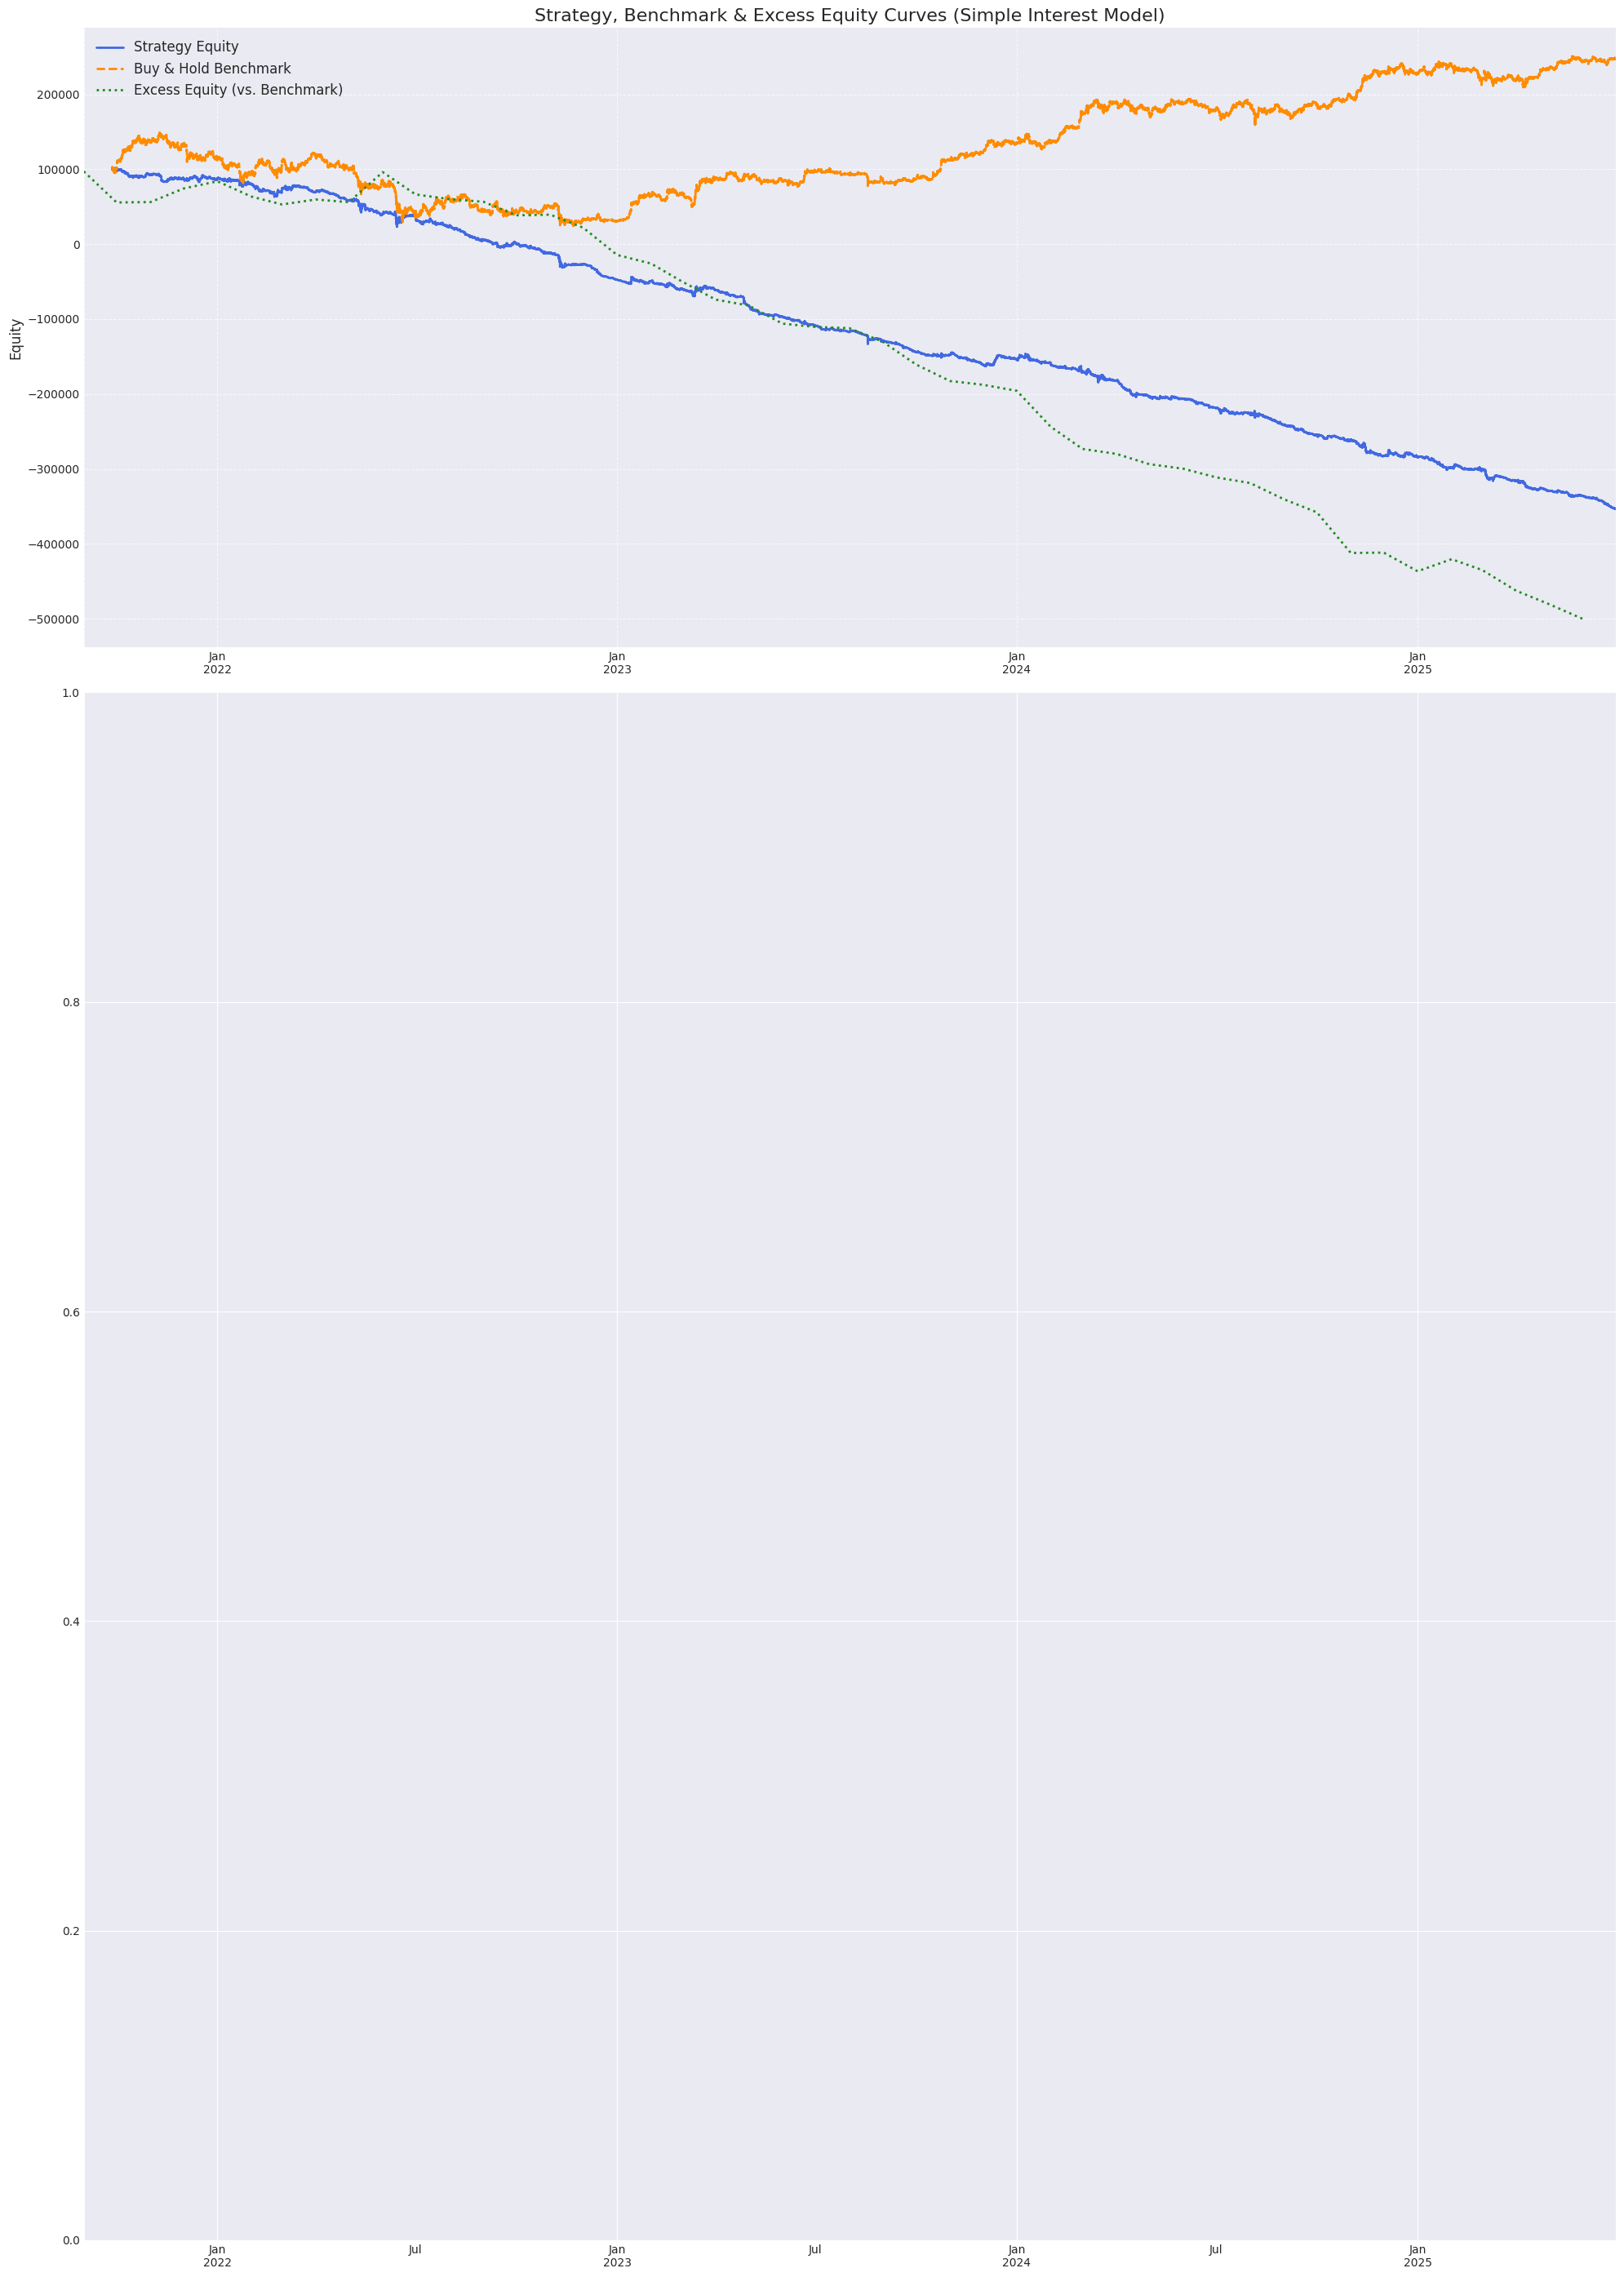

2025-07-23 14:49:02,378 - INFO - 🎊🎊🎊策略评估完成 (单利模型)🎊🎊🎊


In [5]:
if __name__ == '__main__':
    # --- 参数配置 ---
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    COMMISSION_RATE = 0.0002
    INITIAL_CAPITAL = 100000
    LONG_THRESHOLD = 0.5
    SHORT_THRESHOLD = -0.5
    EVALUATION_CRITERIA = {
        'sharpe_ratio': 2.0,
        'calmar_ratio': 5.0,
        'expectancy': 0.25,
        'max_drawdown': 0.20,
        'weekly_frequency': 5
    }

    # --- 步骤 1: 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    try:
        backtest_data = pd.read_pickle(FILE_PATH)
        logging.info("数据加载成功。")
    except FileNotFoundError:
        logging.error(f"错误: 文件未找到 at {FILE_PATH}. 请确认路径是否正确。")
        exit()

    # --- 步骤 2: 执行回测 (调用单利模型版本) ---
    backtest_results = run_vectorized_backtest(
        prices=backtest_data['close'],
        signals=backtest_data['signal'],
        initial_capital=INITIAL_CAPITAL,
        commission_rate=COMMISSION_RATE,
        long_threshold=LONG_THRESHOLD,
        short_threshold=SHORT_THRESHOLD
    )
    
    # --- 步骤 3: 性能评估 (调用适配单利模型的评估函数) ---
    evaluate_performance(
        backtest_results=backtest_results,
        evaluation_criteria=EVALUATION_CRITERIA,
        initial_capital=INITIAL_CAPITAL,
        factor_data=None 
    )